In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
from fastai.vision.all import *

In [3]:
torch.cuda.empty_cache()

In [4]:
pd.set_option('display.max_rows', 500)

In [5]:
path = Path()/'data'
path.ls()

(#8) [Path('data/.~lock.labels.csv#'),Path('data/readme.txt'),Path('data/train_images_small'),Path('data/labels.csv'),Path('data/.ipynb_checkpoints'),Path('data/train_images'),Path('data/video_clips'),Path('data/models')]

# Splitting video clips into training and validation sets

This competition presents a unique sampling challenge. Labels in the dataset are specified at the video level, whereas training data are images extracted from these video clips. This makes data sampling slightly tricky. A naive strategy could be to merely replicate the label of videos to which the image belongs, so what is the fuss. It sounds interesting on the surface, but there is a glitch. If we randomly split images based on the video clip labels, we will likely introduce data leakage as images from the same videos can end up in both datasets. This is exactly what happened to us. We fell victim to this error and found our model is yielding impressive results. When we were finalising the code to generate one result per video from its images, we realised that this naive sampling strategy is making the model cheat. We needed to implement a strategy that ensures images from one video only end up in one dataset, i.e., either training or validation. Likewise, we wanted datasets with a realistic distribution of videos for each combination of tools used in the surgery. A small investigation revealed various combinations of tools that can only exist in just one video. Now, where should these videos be sampled? We will definitely get KeyError if such videos are blindly assigned to the validation set. The model might not create the tool category during the vocab creation since non of the images from training images have seen the robot using that tool. The default choice will always be keeping these videos in the training set, which will fix the KeyError. But hang on a minute, how our model will learn to predict tools for these robotic arms if there is nothing in the validation set to compare its performance and guide the gradient descent. There shall be a strategy to distribute data from rare videos into both datasets. Randomly sampling data from rare videos will obviously introduce more leakage where a sampling logic to add the later images from rare videos to the validation set and leaving the earlier in the video in the training set seems to be a wise strategy. We carefully implemented our sampling strategy and covered all these cases to avoid data leakage. This could be seen from our training results which seem more realistic and fall in the range of 14-20 per cent. 

In [6]:
df = pd.read_csv(path/'labels.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

trn_df=trn=val_df=val=pd.DataFrame(data=None, columns=df.columns)
for i in df.tools_present.unique():
    df_tmp = df.loc[df['tools_present']==i]
    trn,val=np.split(df_tmp, [int(.7*len(df_tmp))])
    if len(trn)>0: trn_df=pd.concat([trn_df, trn])
    else: trn_df=pd.concat([trn_df, val])
    if len(trn)>0: val_df=pd.concat([val_df, val])
    
trn_df['valid']=False
val_df['valid']=True
df = pd.concat([trn_df,val_df])
df.sort_values(by='clip_name', inplace=True)
df.set_index('clip_name', inplace=True)
df

,tools_present,valid
clip_name,,
clip_000000,"[needle driver, nan, needle driver, cadiere forceps]",False
clip_000001,"[needle driver, nan, needle driver, cadiere forceps]",False
clip_000002,"[needle driver, nan, needle driver, cadiere forceps]",False
clip_000003,"[needle driver, nan, needle driver, cadiere forceps]",False
clip_000004,"[needle driver, nan, needle driver, cadiere forceps]",False
...,...,...
clip_024716,"[bipolar forceps, nan, monopolar curved scissors, grasping retractor]",True
clip_024717,"[bipolar forceps, nan, monopolar curved scissors, grasping retractor]",True
clip_024718,"[bipolar forceps, nan, monopolar curved scissors, grasping retractor]",True


In [7]:
# def random_cutter(df,valid_pct=0.2):
#     idxs = L(list(torch.randperm(len(df)).numpy()))
#     cut = int(len(df) * valid_pct)
#     return idxs[cut:], idxs[0:cut] 

# train_split, valid_split = random_cutter(df,0.3)
# df['valid']=True
# df.loc[valid_split,'valid']=False
# df.set_index('clip_name', inplace=True)

In [8]:
df.valid.value_counts()

False    17224
True      7471
Name: valid, dtype: int64

Once data is properly splitted, we created a function that accept an image path and then extracts the parent label (video clip name) and then use it to search the data frame. We indexed the dataframe based on the clip name so that we can leverage pandas indexing feature. This function returns true if an image belongs to the validation set otherwise false for training set. We used fast.ai's FuncSplitter to harness this function for the desired data sampling.

In [9]:
def split_func(f):
    return df.loc[parent_label(f), 'valid']

In [10]:
def get_usm0_tool_lbl(k):
    return re.sub(r"[\[\]]",'',df.loc[parent_label(k),'tools_present']).split(',')[0].strip()

def get_usm1_tool_lbl(k):
    return re.sub(r"[\[\]]",'',df.loc[parent_label(k),'tools_present']).split(',')[1].strip()

def get_usm2_tool_lbl(k):
    return re.sub(r"[\[\]]",'',df.loc[parent_label(k),'tools_present']).split(',')[2].strip()

def get_usm3_tool_lbl(k):
    return re.sub(r"[\[\]]",'',df.loc[parent_label(k),'tools_present']).split(',')[3].strip()

In [11]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock, CategoryBlock, CategoryBlock, CategoryBlock),
    n_inp=1,
    get_items=get_image_files,
    get_y=[get_usm0_tool_lbl,get_usm1_tool_lbl,get_usm2_tool_lbl,get_usm3_tool_lbl],
    splitter=FuncSplitter(split_func),
    item_tfms=Resize((180,320), method='squish'),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

In [12]:
%time dls = dblock.dataloaders(path/'train_images_small', num_workers=4)

CPU times: user 1min 50s, sys: 293 ms, total: 1min 51s
Wall time: 1min 51s


[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]


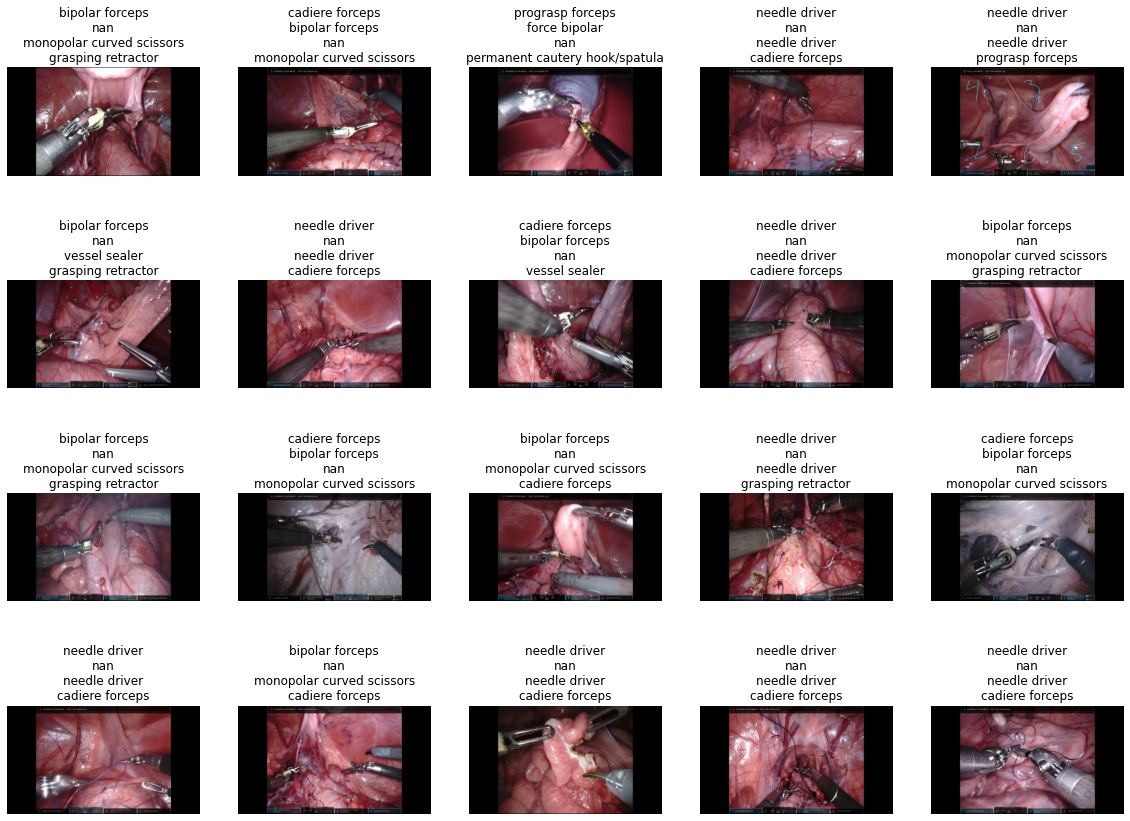

In [13]:
dls.show_batch(max_n=20, figsize=(20,15))

In [14]:
dls.vocab

(#4) [['bipolar forceps', 'cadiere forceps', 'clip applier', 'force bipolar', 'grasping retractor', 'monopolar curved scissors', 'needle driver', 'prograsp forceps', 'tip-up fenestrated grasper', 'vessel sealer'],['bipolar forceps', 'cadiere forceps', 'clip applier', 'force bipolar', 'monopolar curved scissors', 'nan', 'needle driver', 'permanent cautery hook/spatula', 'prograsp forceps', 'vessel sealer'],['bipolar forceps', 'cadiere forceps', 'clip applier', 'force bipolar', 'monopolar curved scissors', 'nan', 'needle driver', 'permanent cautery hook/spatula', 'stapler', 'suction irrigator', 'vessel sealer'],['bipolar dissector', 'bipolar forceps', 'cadiere forceps', 'clip applier', 'force bipolar', 'grasping retractor', 'monopolar curved scissors', 'needle driver', 'permanent cautery hook/spatula', 'prograsp forceps', 'stapler', 'suction irrigator', 'tip-up fenestrated grasper', 'vessel sealer']]

In [15]:
n0=len(dls.vocab[0])
n1=len(dls.vocab[1])
n2=len(dls.vocab[2])
n3=len(dls.vocab[3])
nt= n0+n1+n2+n3
print(nt)

def usm0_err(inp,usm0_preds,usm1_preds,usm2_preds,usm3_preds): return error_rate(inp[:,:n0], usm0_preds)
def usm1_err(inp,usm0_preds,usm1_preds,usm2_preds,usm3_preds): return error_rate(inp[:,n0:n0+n1], usm1_preds)
def usm2_err(inp,usm0_preds,usm1_preds,usm2_preds,usm3_preds): return error_rate(inp[:,n0+n1:n0+n1+n2], usm2_preds)
def usm3_err(inp,usm0_preds,usm1_preds,usm2_preds,usm3_preds): return error_rate(inp[:,n0+n1+n2:n0+n1+n2+n3], usm3_preds)

def usm0_loss(inp,usm0_preds,usm1_preds,usm2_preds,usm3_preds): return F.cross_entropy(inp[:,:n0], usm0_preds)
def usm1_loss(inp,usm0_preds,usm1_preds,usm2_preds,usm3_preds): return F.cross_entropy(inp[:,n0:n0+n1], usm1_preds)
def usm2_loss(inp,usm0_preds,usm1_preds,usm2_preds,usm3_preds): return F.cross_entropy(inp[:,n0+n1:n0+n1+n2], usm2_preds)
def usm3_loss(inp,usm0_preds,usm1_preds,usm2_preds,usm3_preds): return F.cross_entropy(inp[:,n0+n1+n2:n0+n1+n2+n3], usm3_preds)

def custom_loss(inp,usm0_preds,usm1_preds,usm2_preds,usm3_preds,**kwargs): 
    return usm0_loss(inp,usm0_preds,usm1_preds,usm2_preds,usm3_preds)+usm1_loss(inp,usm0_preds,usm1_preds,usm2_preds,usm3_preds)+usm2_loss(inp,usm0_preds,usm1_preds,usm2_preds,usm3_preds)+usm3_loss(inp,usm0_preds,usm1_preds,usm2_preds,usm3_preds)

custom_metrics = [usm0_loss,usm1_loss,usm2_loss,usm3_loss,usm0_err,usm1_err,usm2_err,usm3_err]

45


In [46]:
ns = tensor([len(v)for v in dls.vocab]); ns

tensor([10, 10, 11, 14])

In [57]:
def cfg (i): return ns[:i].sum().item()

In [58]:
print(cfg(1))

10


In [15]:
arch = 'convnext_small_in22k'

In [ ]:
learn = vision_learner(dls, arch, loss_func=custom_loss, metrics=custom_metrics, n_out=nt).to_fp16()

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(12, 0.01)

In [ ]:
learn.path=Path()/'models'
learn.export('m2-multitarget-all-videos-sparse-data-custom-stratified.pkl')

In [ ]:
probs,_,idxs = learn.get_preds(dl=dls.valid, with_decoded=True)

In [ ]:
usm0=idxs[:,0:n0].softmax(dim=1).argmax(dim=1)
usm1=idxs[:,n0:n0+n1].softmax(dim=1).argmax(dim=1)
usm2=idxs[:,n0+n1:n0+n1+n2].softmax(dim=1).argmax(dim=1)
usm3=idxs[:,n0+n1+n2:n0+n1+n2+n3].softmax(dim=1).argmax(dim=1)

In [ ]:
usm0_mapping={i:k for i,k in enumerate(dls.vocab[0])}; usm0_mapping

In [ ]:
usm1_mapping={i:k for i,k in enumerate(dls.vocab[1])}; usm1_mapping

In [ ]:
usm2_mapping={i:k for i,k in enumerate(dls.vocab[2])}; usm2_mapping

In [ ]:
usm3_mapping={i:k for i,k in enumerate(dls.vocab[3])}; usm3_mapping

In [ ]:
result = pd.DataFrame({'clip_name':[parent_label(i) for i in learn.dl.items]})

# tool in the first arm
result['usm0_tool_idx']= idxs[:,0:n0].softmax(dim=1).argmax(dim=1)
result['usm0_tool_lbl']= result['usm0_tool_idx'].map(usm0_mapping)

# tool in the second arm
result['usm1_tool_idx']= idxs[:,n0:n0+n1].softmax(dim=1).argmax(dim=1)
result['usm1_tool_lbl']= result['usm1_tool_idx'].map(usm1_mapping)

# tool in the third arm
result['usm2_tool_idx']= idxs[:,n0+n1:n0+n1+n2].softmax(dim=1).argmax(dim=1)
result['usm2_tool_lbl']= result['usm2_tool_idx'].map(usm2_mapping)

# tool in the fourth arm
result['usm3_tool_idx']= idxs[:,n0+n1+n2:n0+n1+n2+n3].softmax(dim=1).argmax(dim=1)
result['usm3_tool_lbl']= result['usm3_tool_idx'].map(usm3_mapping)

# combining the tools predicted in one column as per competition format
result['tools_present_pred']= '['+result[['usm0_tool_lbl', 'usm1_tool_lbl', 'usm2_tool_lbl', 'usm3_tool_lbl']].apply(lambda x: ', '.join(x[x.notnull()]), axis = 1)+']'

# including the ground truth column for a reference
# result['tools_present']=[df.loc[parent_label(i),'tools_present'] for i in learn.dl.items]

# deleting duplicates to create one set of tools predictions per clip
result = result.drop_duplicates(subset = ['clip_name','tools_present_pred'])

# verifying there is just one set of tools predicted per clip
assert result['clip_name'].shape[0] == result.shape[0], 'This model has predicted more than one set of tools for frames in a clip'

# sorting results by clip name
result = result[['clip_name','tools_present_pred']].sort_values(by=['clip_name'])

# creating the CSV file for submission
fname='m2-multitarget-all-videos-sparse-model-preds-stratified.csv'
result.to_csv(fname, index=False)
!head {fname}

In [16]:
learn = load_learner('models/m2-multitarget-all-videos-sparse-data-custom-stratified.pkl')

In [17]:
probs,_,idxs = learn.get_preds(dl=dls.valid, with_decoded=True)

In [1]:
dls.valid.items

NameError: name 'dls' is not defined

In [28]:
idxs[:,0:n0].softmax(dim=1).argmax(dim=1)

TensorBase([1, 1, 1,  ..., 0, 0, 0])

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
ClassificationInterpretation.from_learner??

In [ ]:
Path()/'models'

In [ ]:
x = torch.randn((1,37)); x

In [ ]:
n0

In [ ]:
x[:,:n0]

In [ ]:
n1

In [ ]:
x[:,n0:n0+n1]

In [81]:
error_rate??

Signature: error_rate(inp, targ, axis=-1)
Source:   
def error_rate(inp, targ, axis=-1):
    "1 - `accuracy`"
    return 1 - accuracy(inp, targ, axis=axis)
File:      ~/mambaforge/lib/python3.9/site-packages/fastai/metrics.py
Type:      function


In [82]:
accuracy??

Signature: accuracy(inp, targ, axis=-1)
Source:   
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()
File:      ~/mambaforge/lib/python3.9/site-packages/fastai/metrics.py
Type:      function
